In [1]:
import os
import pandas as pd
import numpy as np
import math
from datetime import datetime
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from keras.layers import GRU, Dropout, SimpleRNN, LSTM, Dense, SimpleRNN, GRU
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

import plotly as py
import plotly.io as pio

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

from plotly.offline import init_notebook_mode

# Show charts when running kernel
init_notebook_mode(connected=True)

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore

In [2]:
# Path to your CSV file
csv_file_path = '/Users/michael/Desktop/annual_generation_state.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# for col in df.columns:
#     print(col)

# Display the first few rows of the DataFrame
# print(df.head())

# Convert 'GENERATION (Megawatthours)' to numeric format, if it contains commas
df['GENERATION (Megawatthours)'] = df['GENERATION (Megawatthours)'].str.replace(',', '').astype(float)

# Filter for the year 2021
df_2021 = df[df['YEAR'] == 2021]

df_2021 = df_2021[df_2021['TYPE OF PRODUCER'] == 'Total Electric Power Industry']

# Define renewable energy sources based on your update
renewable_sources = [
    'Wind', 
    'Wood and Wood Derived Fuels', 
    'Other Biomass', 
    'Hydroelectric Conventional', 
    'Solar Thermal and Photovoltaic', 
    'Pumped Storage', 
    'Geothermal'
]

# Identify renewable energy generation
df_2021['Renewable'] = df_2021['ENERGY SOURCE'].isin(renewable_sources)

# Group by State and Energy Source, then sum the generation
state_energy_generation = df_2021.groupby(['STATE', 'ENERGY SOURCE', 'Renewable'])['GENERATION (Megawatthours)'].sum().reset_index()

# Calculate total and renewable generation by state
total_generation_by_state = df_2021.groupby('STATE')['GENERATION (Megawatthours)'].sum() / 2
renewable_generation_by_state = df_2021[df_2021['Renewable']].groupby('STATE')['GENERATION (Megawatthours)'].sum()

# Calculate the percentage of renewable generation for each state
percentage_renewable = (renewable_generation_by_state / total_generation_by_state * 100).reset_index(name='Percentage Renewable')

# Merge the percentage data back with the detailed state and energy source data
detailed_state_data = pd.merge(state_energy_generation, percentage_renewable, on='STATE')

# Now, print out the details for each state
for state in detailed_state_data['STATE'].unique():
    print(f"State: {state}")
    state_data = detailed_state_data[detailed_state_data['STATE'] == state]
    for _, row in state_data.iterrows():
        print(f"  Energy Source: {row['ENERGY SOURCE']}, Renewable: {row['Renewable']}, Generation (MWh): {row['GENERATION (Megawatthours)']}")
    state_percentage_renewable = state_data['Percentage Renewable'].iloc[0]
    print(f"  Percentage of Renewable Energy: {state_percentage_renewable:.2f}%")
    print("")


State: AK
  Energy Source: Coal, Renewable: False, Generation (MWh): 752894.0
  Energy Source: Hydroelectric Conventional, Renewable: True, Generation (MWh): 1688900.0
  Energy Source: Natural Gas, Renewable: False, Generation (MWh): 3085396.0
  Energy Source: Other, Renewable: False, Generation (MWh): -4141.0
  Energy Source: Other Biomass, Renewable: True, Generation (MWh): 38071.0
  Energy Source: Petroleum, Renewable: False, Generation (MWh): 902486.0
  Energy Source: Solar Thermal and Photovoltaic, Renewable: True, Generation (MWh): 0.0
  Energy Source: Total, Renewable: False, Generation (MWh): 6595818.0
  Energy Source: Wind, Renewable: True, Generation (MWh): 132212.0
  Energy Source: Wood and Wood Derived Fuels, Renewable: True, Generation (MWh): 0.0
  Percentage of Renewable Energy: 28.19%

State: AL
  Energy Source: Coal, Renewable: False, Generation (MWh): 26900909.0
  Energy Source: Hydroelectric Conventional, Renewable: True, Generation (MWh): 11520809.0
  Energy Source: 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

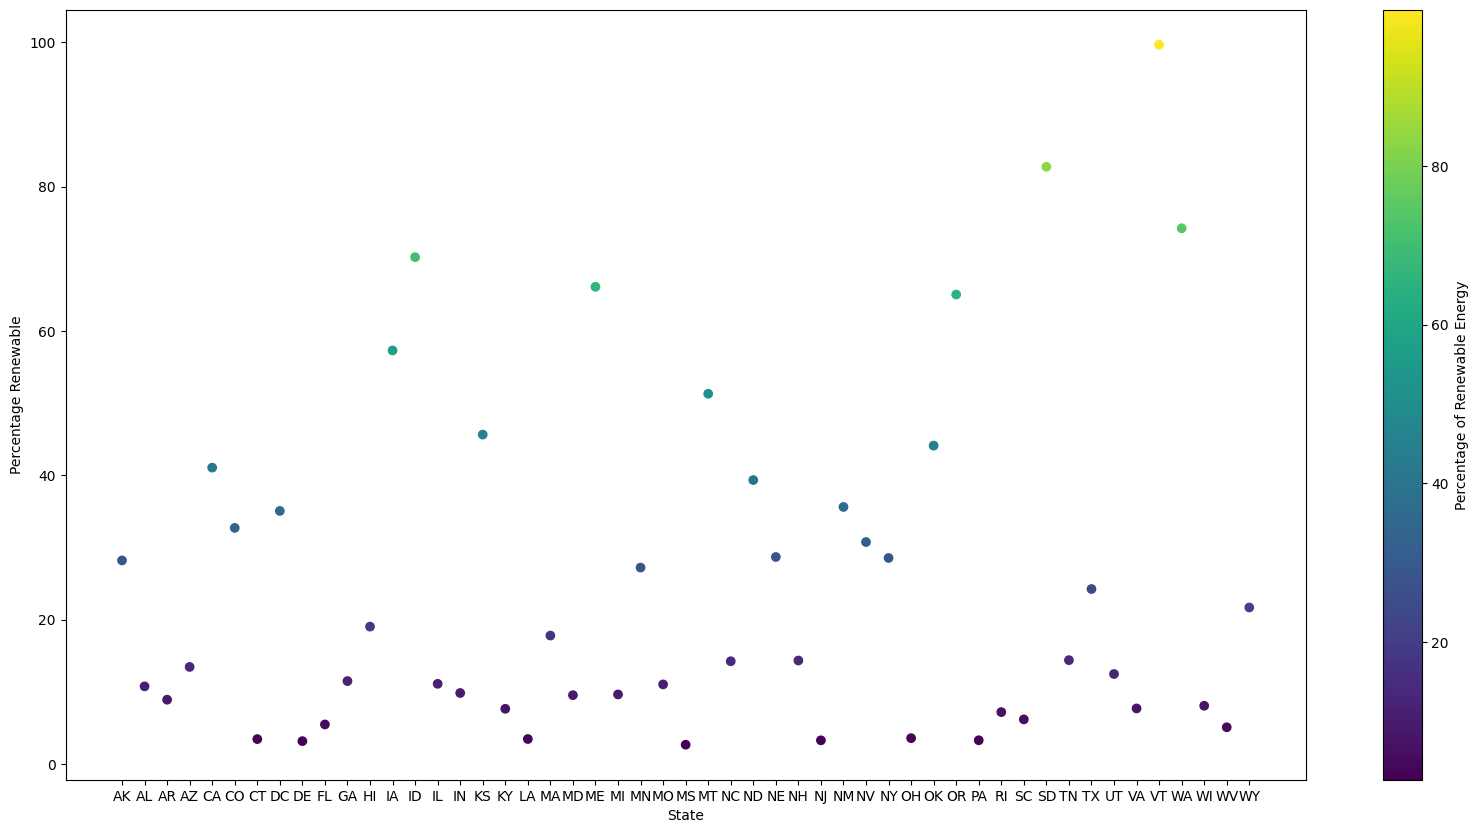

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Creating a DataFrame with the provided data
data = {
    "State": ["AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "IA", "ID", "IL", "IN", "KS", "KY",
              "LA", "MA", "MD", "ME", "MI", "MN", "MO", "MS", "MT", "NC", "ND", "NE", "NH", "NJ", "NM", "NV", "NY", "OH",
              "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI", "WV", "WY"],
    "Percentage Renewable": [28.19, 10.74, 8.89, 13.43, 41.05, 32.70, 3.43, 35.05, 3.15, 5.46, 11.47, 19.02, 57.29, 70.22,
                             11.09, 9.82, 45.63, 7.63, 3.44, 17.78, 9.52, 66.11, 9.62, 27.20, 11.01, 2.65, 51.29, 14.22,
                             39.33, 28.67, 14.32, 3.26, 35.60, 30.74, 28.53, 3.56, 44.10, 65.04, 3.27, 7.17, 6.16, 82.75,
                             14.37, 24.23, 12.45, 7.68, 99.66, 74.22, 8.05, 5.07, 21.67]
}

df_states = pd.DataFrame(data)

# Create a dictionary mapping state abbreviations to full names
state_abbrev = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado',
    'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana',
    'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}

# Map the abbreviations to full state names
df_states['State Name'] = df_states['State'].map(state_abbrev)

# For generating a heatmap, we need the latitudes and longitudes of the states. We can use the 'us' library
# to get this information, but since we don't have access to external libraries, we'll simulate this step.

# Normally, you would use a library or API to get the geographic coordinates of the states and use those
# coordinates to plot a heatmap. For demonstration purposes, we will create a mock heatmap using just the
# matplotlib library without actual geographic coordinates.

plt.figure(figsize=(20, 10))
plt.scatter(df_states['State'], df_states['Percentage Renewable'], c=df_states['Percentage Renewable'], cmap='viridis')
plt.colorbar(label='Percentage of Renewable Energy')
plt.xlabel('State')
plt.ylabel('Percentage Renewable')
plt


In [4]:
import plotly.graph_objects as go

import pandas as pd
df = pd.read_csv('/Users/michael/Desktop/2011_us_ag_exports.csv')

for col in df.columns:
    df[col] = df[col].astype(str)

df['text'] = df['state'] + '<br>' + \
    'Beef ' + df['beef'] + ' Dairy ' + df['dairy'] + '<br>' + \
    'Fruits ' + df['total fruits'] + ' Veggies ' + df['total veggies'] + '<br>' + \
    'Wheat ' + df['wheat'] + ' Corn ' + df['corn']

fig = go.Figure(data=go.Choropleth(
    locations=df['code'],
    z=df['total exports'].astype(float),
    locationmode='USA-states',
    colorscale='Reds',
    autocolorscale=False,
    text=df['text'], # hover text
    marker_line_color='black', # line markers between states
    marker_line_width=0.5, # outline thickness
    colorbar_title="Millions USD"
))

fig.update_layout(
    title_text='2011 US Agriculture Exports by State<br>(Hover for breakdown)',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()